### Step-back

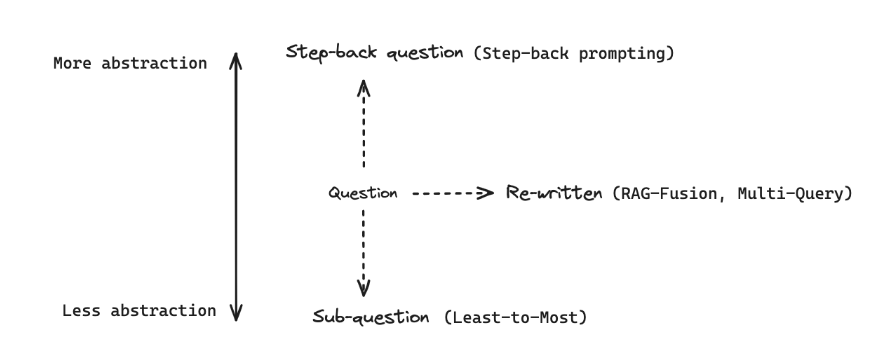

In [1]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [2]:

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7, )

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.output_parsers import StrOutputParser

generate_queries_step_back = prompt | llm | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'How can complex tasks be broken down for AI systems? \n'

In [4]:
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

persist_dir = "chromadb"
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

newdb = Chroma(persist_directory=persist_dir, embedding_function=embedding_function)
retriever = newdb.as_retriever()

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


In [5]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down a complex task into smaller, more manageable subtasks that an LLM can effectively handle. This is a crucial step in designing LLM agents that can perform complex, multi-step operations.\n\nHere\'s a breakdown of the key aspects of task decomposition for LLM agents:\n\n**1. Identify the Overall Task:**\n   - Clearly define the goal or objective the agent needs to achieve. This could be anything from writing a creative story to summarizing a research paper or managing a social media account.\n\n**2. Break Down the Task:**\n   - Analyze the overall task and identify the distinct subtasks required to complete it.\n   - Each subtask should be relatively independent and well-defined. \n   - Consider the capabilities of the LLM and ensure that each subtask is within its scope.\n\n**3. Order the Subtasks:**\n   - Determine the logical order in which the subtasks need to be executed. \n   - Some tasks may have dependencie